# Heatmap and Radial Barchart

## Import libraries

Matplotlib, Numpy, and Pandas power trio is all we're gonna use today.

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Note: Before getting started with any data manipulation step, you may update Matplotlib's `rcParams` to use the **Roboto Condensed** font instead of the default one.

In [2]:
plt.rcParams.update({"font.family": "Arial"})

https://raw.githubusercontent.com/nnthanh101/Machine-Learning/main/analytics/data/plastic.md

## Load and prepare the data

The data for this article comes from [Break Free from Plastic](https://www.breakfreefromplastic.org/) courtesy of [Sarah Sauve](https://sarahasauve.wordpress.com/). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2021-01-26. You can more information in the original announcement [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-01-26/readme.md). Thank you all for making this guide possible! 🙏🙏

The first step is to read the CSV file from the web.

In [3]:
path = "https://raw.githubusercontent.com/nnthanh101/Machine-Learning/main/analytics/data/plastics.csv"
data = pd.read_csv(path)

Then, we compute the total plastic waste for each type of plastic, by company and year.

In [4]:
types_of_plastic = ["empty", "hdpe", "ldpe", "o", "pet", "pp", "ps", "pvc"]
total_by_company = (
    data
    .groupby(["parent_company", "year"], dropna=True)[types_of_plastic]
    .sum()
    .reset_index()
)
total_by_company

,parent_company,year,empty,hdpe,ldpe,o,pet,pp,ps,pvc
0,"""ESE""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Inko"" noodles / Ð®Ñ„ÐºÐ° â€œÐ˜Ð½ÐºÐ¾""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Мелочи Жизни"" (Ооо Ергопак)",2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,#ERROR!,2020,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4,(Local Factory),2020,0.0,0.0,0.0,0.0,9.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11215,Ямуна,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
11216,Янтар,2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11217,Янтар (Сан Інбев Україна),2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11218,Янтарь,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


The `get_top_n_data()` function gives the n companies that had the largest plastic waste. It performs several data manipulation steps that are explained with inline comments.

In [5]:
def get_top_n_data(data, n):
    """Create data frame with plastic values for the top-n companies and one Others group."""

    # Analyses data from 2020 only
    # Compute the total plastic waste per company
    top_data = (
        data
        .query("year == 2020")
        .melt(
            id_vars=["parent_company", "year"], 
            value_vars=types_of_plastic, 
            var_name="type"
        )
        .groupby("parent_company")["value"]
        .sum()
        .reset_index()
    )

    # Use "Unbranded_unknown" for unbranded/unknown/error cases
    top_data["parent_company"] = np.where(
        top_data["parent_company"].isin(["Unbranded", "null", "NULL", "#ERROR!"]), 
        "Unbranded_unknown",
        top_data["parent_company"]
    )

    # Create a list of top companies.
    # This list contains the top n companies with largest plastic waste.
    top_companies = list(top_data.sort_values("value", ascending=False)["parent_company"][:n])

    # Create a lumped version of the company variable. 
    # If "parent_company" is one of the top companies, it gets its original name. 
    # Otherwise, it's labelled with "Other"
    top_data["company_lumped"] = np.where(
        top_data["parent_company"].isin(top_companies),
        top_data["parent_company"],
        "Other"
    )

    # Merge `top_data` with `total_by_company`
    top_data = top_data.drop_duplicates(["parent_company", "company_lumped"])
    top_data = top_data.merge(total_by_company, on="parent_company")

    # Sum all types of plastic except from 'empty' into the "total" variable
    top_data["total"] = top_data.loc[:, types_of_plastic[1:]].sum(axis=1)

    return top_data

## Heatmap

The first plot in the visualization we're trying to reproduce is a heatmap. This heatmap shows the proportion of plastic waste per plastic type for the top 30 companies. 

Let's roll up our sleves and get to work on shaping this dataset!

In [6]:
top_thirty = get_top_n_data(total_by_company, n=30)

# For each company, compute the total waste per each type of plastic
top_thirty = (
    top_thirty
    .groupby("company_lumped")[types_of_plastic]
    .sum()
    .reset_index()
)

# Add a column with the sum of the plastic waste for all types of plastic
top_thirty["row_sum"] = top_thirty.loc[:, types_of_plastic].sum(axis=1)

# Divide the waste of each type of plastic by the total waste to get the proportion of waste for
# each type of plastic
top_thirty[types_of_plastic] = top_thirty[types_of_plastic].apply(lambda x: x / top_thirty["row_sum"])

# Unpivot data
top_thirty = top_thirty.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="proportion"
)

top_thirty

,company_lumped,type,proportion
0,Bakhresa Group,empty,0.000000
1,Blow-Chem Industries,empty,0.000000
2,Britannia,empty,0.000000
3,Colgate-Palmolive,empty,0.000611
4,Cway Group,empty,0.000000
...,...,...,...
235,Unilever,pvc,0.002212
236,Universal Robina Corporation,pvc,0.005780
237,Voltic Ghana Limited,pvc,0.000000
238,W.L. Food Products,pvc,0.000000


It's important to make sure company names are sorted appropriately. Company names are sorted alphabetically, except from `"Others"` which goes in the last place.

In [7]:
# Get company names
categories = list(top_thirty["company_lumped"].unique())
# Sort categories according to their lowercase version (this step is important!)
sorted_categories = sorted(categories, key=str.lower)
# Remove "Other" from the list and append it to the tail
sorted_categories.remove("Other")
sorted_categories.append("Other")

Now use these categories to convert the `"company_lumped"` variable into an ordered categorical variable.

In [8]:
top_thirty["company_lumped"] = pd.Categorical(
    top_thirty["company_lumped"], 
    categories=sorted_categories, 
    ordered=True
)

# Finally, sort the values in the data frame according to this custom sort.
top_thirty = top_thirty.sort_values("company_lumped", ascending=False)

Finally, let's create the colormap for the heatmap. These colors are obtained from the `"YlGnBu"` palette in the `RColorBrewer` package in [R](https://www.r-graph-gallery.com/).

In [9]:
# Define colors
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)

Since we plan to plot the heatmap more than once, it's a good idea to create a function to perform this task. Have a look to the comments if you want to understand the details 😉

In [10]:
def plot_heatmap(ax):
    # Iterate over types of plastic
    for i, plastic in enumerate(types_of_plastic):
        # Select data for the given type of plastic
        d = top_thirty[top_thirty["type"] == plastic]

        # Get values for the x and y axes
        y = d["company_lumped"]
        x = [i] * len(y)
        
        # Generate colors. No need to normalize since proportions are between 0 and 1.
        color = cmap(d["proportion"]) 
        
        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=120)

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(types_of_plastic)))

    # Set labels for the x ticks (the names of the types of plastic)
    ax.set_xticklabels(types_of_plastic)

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")

    # Set label for horizontal axis.
    ax.set_xlabel("Type of plastic", loc="right")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)
    
    return ax

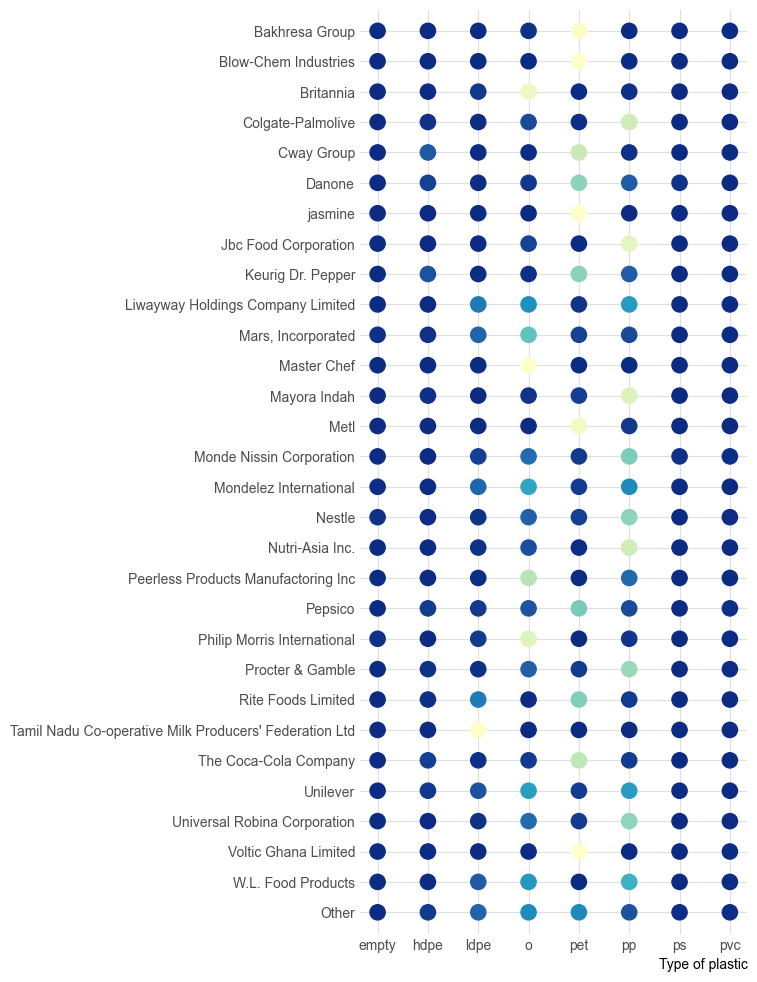

In [11]:
fig, ax = plt.subplots(figsize=(5, 12))
plot_heatmap(ax);

Not a bad start!! 😁

## Circular barplots

Now it's time to start working on the second chart in the visualization. This one is made of six circular barplots for the top 6 companies in terms of plastic waste.

In [12]:
# Top 6 companies palettes, from design-seeds.com
COMPANY_PALETTES = ["#81C4CA", "#468D96", "#103128", "#E83D5F", "#FA6E90", "#FCB16D"]

Again, some data processing is needed:

In [13]:
top_seven = get_top_n_data(total_by_company, n=7)

# Unpivot data
top_seven = top_seven.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="amount"
)

# Drop entries where company is unbranded/unknown or other
top_seven = top_seven[~top_seven["company_lumped"].isin(["Unbranded_unknown", "Other"])]

# Drop entries where plastyic type is either "ps", "pvc", or "empty"
top_seven = top_seven[~top_seven["type"].isin(["ps", "pvc", "empty"])]

# For each company and type of plastic, compute the sum of plastic waste
top_seven = top_seven.groupby(["company_lumped", "type"]).sum().reset_index()

# Rename "amount" to "total"
top_seven = top_seven.rename({"amount": "total"}, axis=1)

# Compute the proportion of plastic waste for each type within each company
top_seven["prop"] = top_seven["total"] / top_seven.groupby("company_lumped")["total"].transform("sum")

And now, let's start creating functions for our chart! 

First, there is this auxiliary function that takes a circular axis object and applies some styles and customizations:

In [14]:
def style_polar_axis(ax):
    # Change the initial location of the 0 in radians
    ax.set_theta_offset(np.pi / 2)
    
    # Move in clock-wise direction 
    ax.set_theta_direction(-1)

    # Remove all spines
    ax.set_frame_on(False)

    # Don't use tick labels for radial axis
    ax.set_xticklabels([])
    
    # Set limits for y axis
    ax.set_ylim([0, 4.5])
    # Set ticks for y axis. These determine the grid lines.
    ax.set_yticks([0, 1, 2, 3, 4, 4.5])
    # But don't use tick labels
    ax.set_yticklabels([])
    
    # Set grid with some transparency
    ax.grid(alpha=0.4)

    return ax

Then, the following function takes an axis and a color, and adds the labels corresponding to each line in each circular plot:

In [15]:
def add_labels_polar_axis(ax, color):
    # Define the characteristics of the bbox behind the text we add
    bbox_dict = {
        "facecolor": "w", "edgecolor": color, "linewidth": 1, 
        "boxstyle": "round", "pad": 0.15
    }
    types_of_plastic = ["hdpe", "ldpe", "o", "pet", "pp"]
    # Iterate over types of plastics and add the labels
    for idx, plastic in enumerate(types_of_plastic):
        ax.text(
            0, idx, plastic, color=color, ha="center", va="center",
            fontsize=11, bbox=bbox_dict
        )
    return ax

Finally, the one that creates the chart itself:

In [16]:
def plot_circular(axes):
    axes_flattened = axes.ravel()
    companies = top_seven["company_lumped"].unique()
    
    # Iterate over companies and plots
    for i, company in enumerate(companies):
        # Select data for the given company
        d = top_seven[top_seven["company_lumped"] == company]
        
        # Select plot
        ax = axes_flattened[i]
        
        # Only for the first panel, add label for vertical axis
        if i == 0:
            ax.set_ylabel("Type of plastic", loc="top")
        
        # Adjust style of the plot
        ax = style_polar_axis(ax)
        
        # Multiply the proportion by the 2pi, the complete rotation 
        proportions = d["prop"].values * (2 * np.pi)
        
        # Positions for the lines on the radial
        y_pos = np.arange(len(proportions))
        
        # Construct the line for each type of plastic creating a grid for the x and y values
        x = np.linspace(0, proportions, num=200)
        y = np.vstack([y_pos] * 200)

        # Select color
        color = COMPANY_PALETTES[i]
        
        # And finally, plot the rounded lines
        ax.plot(x, y, lw=6, color=color, solid_capstyle="round")
        
        # Add title
        ax.set_title(company, pad=10, color="0.3")
        
        # Add labels on top of the lines
        ax = add_labels_polar_axis(ax, color)
    return axes

Curious to see how it looks like? Let's do it!

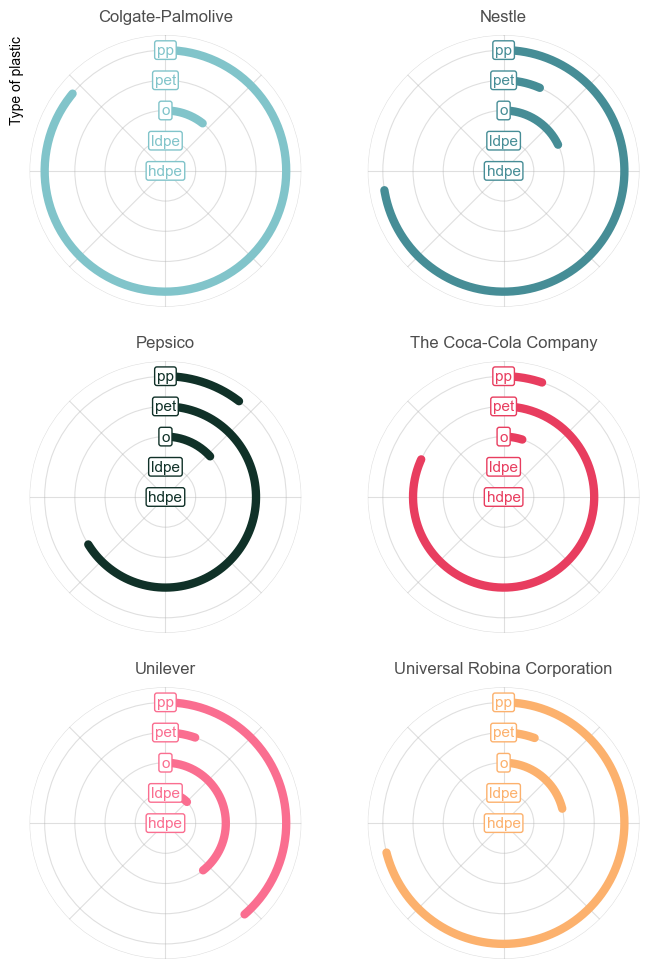

In [17]:
# Initialize layout
fig, axes = plt.subplots(3, 2, figsize=(8, 12), subplot_kw={"projection": "polar"})

# Create chart! 
axes = plot_circular(axes)

Awesome! We're getting closer to the final result!

## Final chart

In this last step, we need to combine the two charts created above. To do so, we create an empty figure and then we add gridspecs to it.

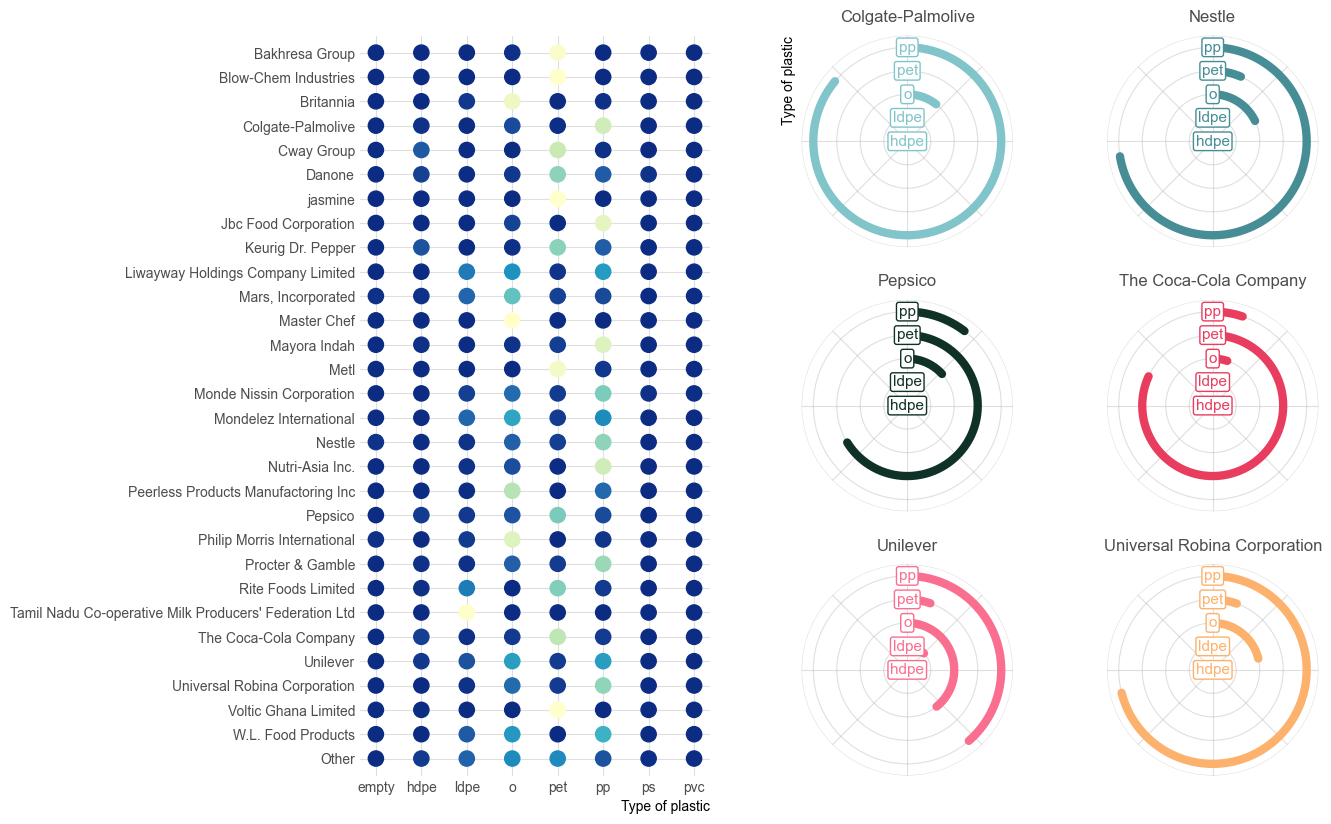

In [18]:
# Create figure
fig = plt.figure(figsize=(14, 10))

# Add first grid spec, for the heatmap
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.25, right=0.5, top=0.85)

# Add the subplot in the gridspec.
ax = fig.add_subplot(gs1[0])

# With the axis returned, plot the heatmap
plot_heatmap(ax)

# Create an empty list to hold the six axes
axes = []
# Add second gridspec. 
gs2 = fig.add_gridspec(nrows=3, ncols=2, left=0.55, right=0.95, hspace=0.25, top=0.85)
# Add all the six axes to the figure, appending the returned axis to the 'axes' list
for gs in gs2:
    axes.append(fig.add_subplot(gs, projection="polar"))

# Convert the list into an array
axes = np.array(axes)

# And now plot the circular barplots
plot_circular(axes);

Terrific!

What's needed now to reach the final version is to add a titles and some annotations that make the chart much more informative.

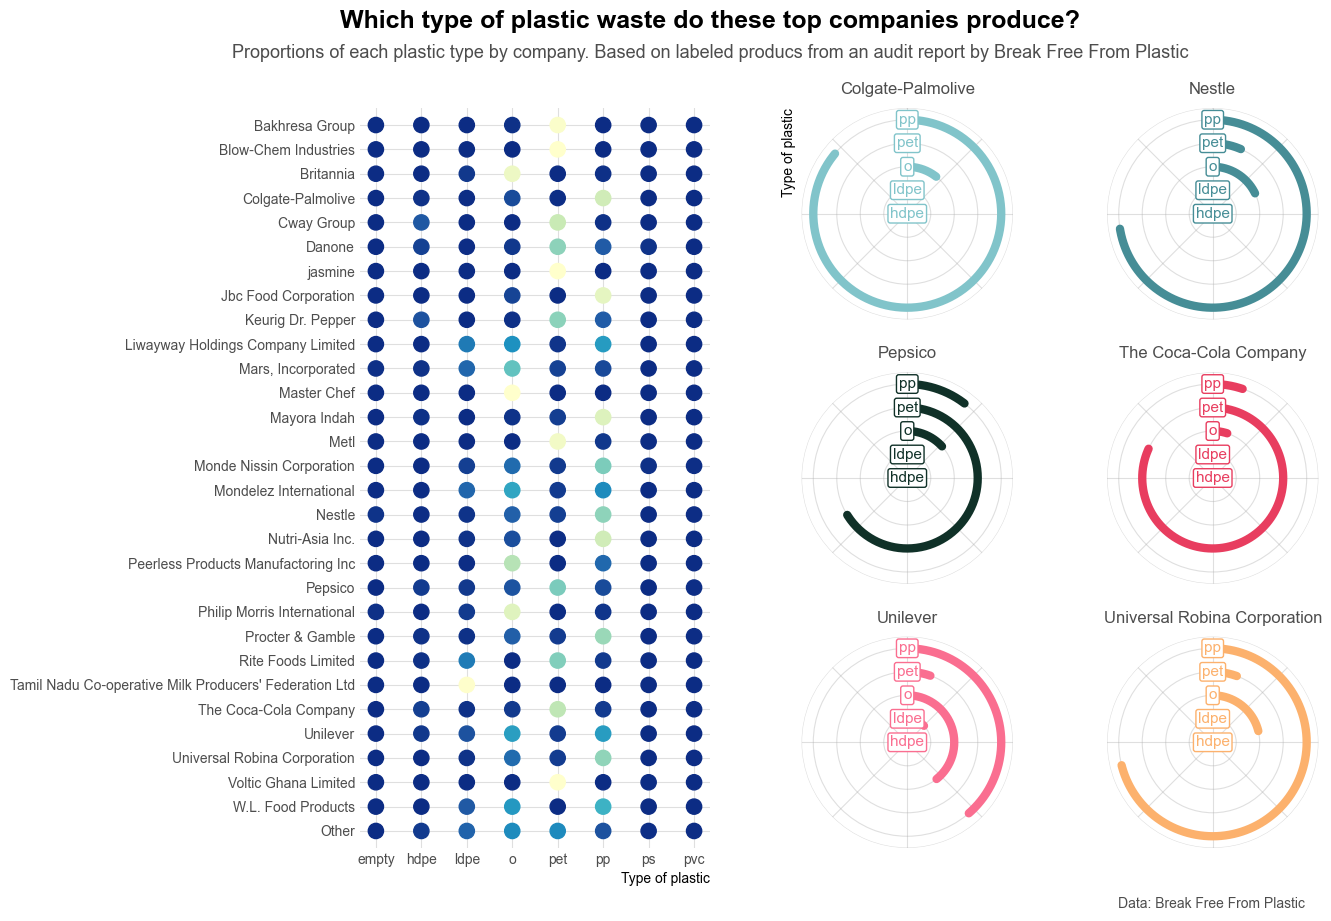

In [19]:
# Add title
fig.text(
    0.5, 0.93, "Which type of plastic waste do these top companies produce?",
    ha="center", va="baseline", size=18, weight="bold"
)

# Add subtitle
fig.text(
    0.5, 0.9, 
    "Proportions of each plastic type by company. Based on labeled producs from an audit report by Break Free From Plastic",
    ha="center", va="baseline", size=13, color="0.3"
)

# Add caption
fig.text(0.925, 0.05, "Data: Break Free From Plastic", color="0.3", ha="right")
fig.set_facecolor("w")

# Print figure
fig
#fig.savefig("plot.png", dpi=300) # if you want to save in high-quality ;)


We nailed it!! 🎉🎉

## The extra mile: Colormaps

You may recall the colormap for the heatmap has been created manually the following line of code:

```python
mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)
```

If you are familiar with built-in colormaps in Matplotlib, you may know there's actually a builtin **YlGnBu** colormap that we can access with `plt.get_cmap("YlGnBu")`. Let's have a look at it:

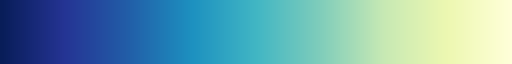

In [20]:
cmap_mpl = plt.get_cmap("YlGnBu")
cmap_mpl = cmap_mpl.reversed()
cmap_mpl

So why we decided to create a colormap manually when we could have used the builtin one? Let's see a comparison!

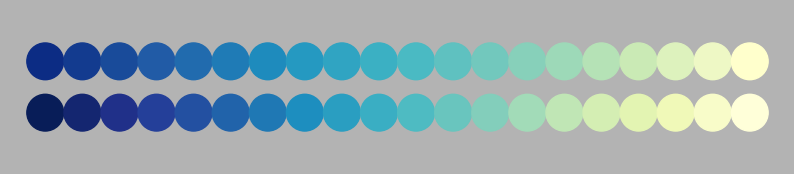

In [21]:
fig, ax = plt.subplots(figsize = (10, 2))

x = np.linspace(0, 1, num=20)
ax.set_ylim(-3, 3)
ax.scatter(x, [1] * 20, color=cmap(x), s=700)
ax.scatter(x, [-1] * 20, color=cmap_mpl(x), s=700)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("0.7")
fig.set_facecolor("0.7")

The differences in the blues are subtle but enough to be perceived by an attentive eye.

## About

This page showcases the work of [Margaret Siple](https://twitter.com/margaretsiple), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on her GitHub repository [here](https://github.com/mcsiple/tidytuesday/blob/master/2021/5_2021_plastics.R), written in [R](https://www.r-graph-gallery.com).

Thanks also to [Tomás Capretto](https://tcapretto.netlify.app/) who translated this work from R to Python! 🙏🙏